In [1]:
import torch
import os

In [197]:
outputs_path = "/mnt/scratch/kf237/experiments/textCNN_first_tries/outputs_trained_subclasses.pt"
print(os.path.exists(outputs_path))

True


In [184]:
outputs_path = "/mnt/scratch/kf237/experiments/textCNN_first_tries/outputs_trained_superclasses.pt"
print(os.path.exists(outputs_path))

True


In [185]:
### CNN

outputs = torch.load(outputs_path)


In [186]:
selected_conv = "convs.0"

##### trained_on_subclasses

In [206]:
print(type(outputs))

print(outputs.keys())

last_epoch = list(outputs.keys())[-1]

print(last_epoch)

epoch_outputs = outputs[last_epoch]



print(type(epoch_outputs))
print(epoch_outputs.keys())

train_outputs = epoch_outputs["train"]
print(type(train_outputs))
print(train_outputs.keys())
selected_subclass_lables = train_outputs["labels"]

train_activations = train_outputs["activations"]

print(train_activations.keys())




selected_activations = train_activations[selected_conv]

print(selected_activations.shape)

<class 'dict'>
dict_keys([0, 1, 2, 3])
3
<class 'dict'>
dict_keys(['train', 'val'])
<class 'dict'>
dict_keys(['activations', 'labels'])
dict_keys(['convs.0', 'convs.1', 'convs.2'])
torch.Size([42000, 25400])


##### trained_on_superclasses

In [198]:
print(type(outputs))

print(outputs.keys())

last_epoch = list(outputs.keys())[-1]

print(last_epoch)

epoch_outputs = outputs[last_epoch]



print(type(epoch_outputs))
print(epoch_outputs.keys())

train_outputs = epoch_outputs["train"]
print(type(train_outputs))
print(train_outputs.keys())
selected_supeclass_labels = train_outputs["labels"]

train_activations = train_outputs["activations"]

print(train_activations.keys())




selected_activations = train_activations[selected_conv]

print(selected_activations.shape)

<class 'dict'>
dict_keys([0, 1, 2, 3])
3
<class 'dict'>
dict_keys(['train', 'val'])
<class 'dict'>
dict_keys(['activations', 'labels'])
dict_keys(['convs.0', 'convs.1', 'convs.2'])
torch.Size([42000, 25400])


In [193]:
print(np.unique(np.array(selected_supeclass_labels)))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


In [196]:
aaaaa = selected_activations.max(dim=-1).values

print(aaaaa.shape)

print(selected_activations.shape)

torch.Size([42000])
torch.Size([42000, 25400])


### continue

In [207]:
import numpy as np


unique_subclass, counts_subclass = np.unique(selected_subclass_lables.numpy(), return_counts=True)

In [211]:

ont_1_mapping = {
        0: 1, # company : other
        1: 1, # educational institution : other
        2: 0, # artist : person
        3: 0, # athlete : person
        4: 0, # office holder : person
        5: 1, # mean of transportation : other
        6: 2, # building : place
        7: 2, # natural place : place
        8: 2, # village : place
        9: 3, # animal : organism
        10: 3, # plant : organism
        11: 4, # album : artwork
        12: 4, # film : artwork
        13: 4, # writtenWork : artwork
    }


superclasses = [ont_1_mapping[subclass] for subclass in selected_subclass_lables.tolist()]

a,b = np.unique(np.array(superclasses), return_counts=True)

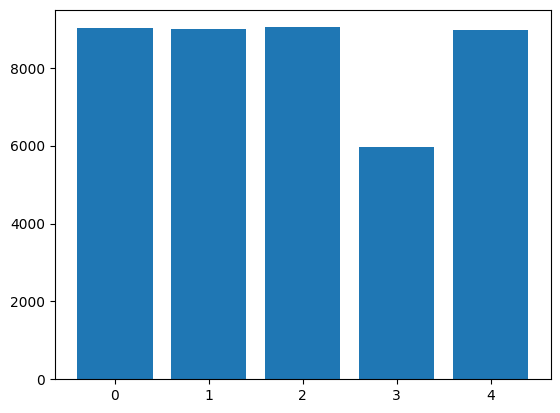

In [212]:
import matplotlib.pyplot as plt

plt.bar(a,b)

plt.show()

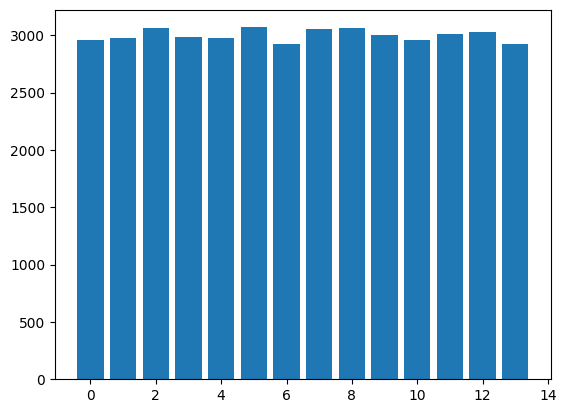

In [208]:
import matplotlib.pyplot as plt



## bar plot

plt.bar(unique_subclass, counts_subclass)
plt.show()

In [189]:
seed = 42

In [190]:
import umap

reducer = umap.UMAP(random_state=seed)

embedding = reducer.fit_transform(selected_activations)


In [191]:

print(embedding.shape)


print(selected_subclass_lables.shape)

(42000, 2)
torch.Size([42000])


###### trained on subllasses

In [ ]:
# Class names
subclass_names = [
    'company', 'educational institution', 'artist', 'athlete', 
    'office holder', 'mean of transportation', 'building', 
    'natural place', 'village', 'animal', 'plant', 
    'album', 'film', 'writtenWork'
]



ont_1_mapping = {
        0: 1, # company : other
        1: 1, # educational institution : other
        2: 0, # artist : person
        3: 0, # athlete : person
        4: 0, # office holder : person
        5: 1, # mean of transportation : other
        6: 2, # building : place
        7: 2, # natural place : place
        8: 2, # village : place
        9: 3, # animal : organism
        10: 3, # plant : organism
        11: 4, # album : artwork
        12: 4, # film : artwork
        13: 4, # writtenWork : artwork
    }


superclasses = [ont_1_mapping[subclass] for subclass in selected_subclass_lables.tolist()]


superclass_names = ["other", "person", "place", "organism", "artwork"]


##### trained on superclasses

In [ ]:
# Class names
subclass_names = [
    'company', 'educational institution', 'artist', 'athlete', 
    'office holder', 'mean of transportation', 'building', 
    'natural place', 'village', 'animal', 'plant', 
    'album', 'film', 'writtenWork'
]



ont_1_mapping = {
        0: 1, # company : other
        1: 1, # educational institution : other
        2: 0, # artist : person
        3: 0, # athlete : person
        4: 0, # office holder : person
        5: 1, # mean of transportation : other
        6: 2, # building : place
        7: 2, # natural place : place
        8: 2, # village : place
        9: 3, # animal : organism
        10: 3, # plant : organism
        11: 4, # album : artwork
        12: 4, # film : artwork
        13: 4, # writtenWork : artwork
    }


##TODO this is impossible to do without the subclass labels....why dif i thought otherwise....


superclasses = [ont_1_mapping_reversed[superclass] for superclass in selected_supeclass_labels.tolist()]


superclass_names = ["other", "person", "place", "organism", "artwork"]

{1: 5, 0: 4, 2: 8, 3: 10, 4: 13}


KeyError: 8

#### continue

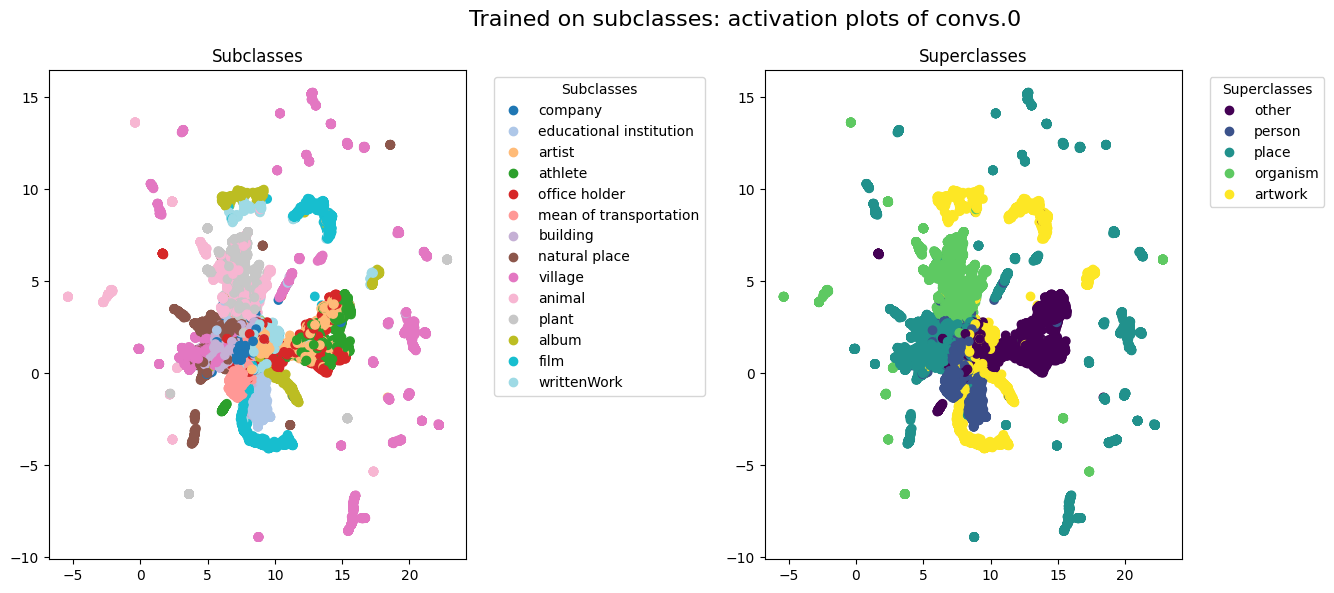

In [102]:
import matplotlib.pyplot as plt
import numpy as np



# Set up the figure and subplots
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))  # Adjust width and height as desired

# Set the overall title for the figure
fig.suptitle(f"Trained on subclasses: activation plots of {selected_conv}", fontsize=16)

# First subplot
scatter1 = axes[0].scatter(embedding[:, 0], embedding[:, 1], c=selected_subclass_lables, cmap="tab20")
legend_elements1, _ = scatter1.legend_elements()
axes[0].legend(legend_elements1, subclass_names, title="Subclasses", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].set_title("Subclasses")

# Second subplot (same data)
scatter2 = axes[1].scatter(embedding[:, 0], embedding[:, 1], c=superclasses, cmap="viridis")
legend_elements2, _ = scatter2.legend_elements()
axes[1].legend(legend_elements2, superclass_names, title="Superclasses", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].set_title("Superclasses")

# Adjust layout to make room for legends and title
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust rect to fit legends and title

# Display plot
plt.show()


In [ ]:
#### filter the activations by class


filtered_superclass = 0



## first  construc the binary mask

superclasses_np = np.array(superclasses)

mask = superclasses_np == filtered_superclass

filtered_activations = selected_activations.numpy()[mask]

filtered_subclass_lables = selected_subclass_lables.numpy()[mask]


unique_labels = np.unique(filtered_subclass_lables)

print(unique_labels)

filtered_subclass_names = [ name for i, name in enumerate(subclass_names) if i in unique_labels]

print(filtered_subclass_names)






[2 3 4]
['artist', 'athlete', 'office holder']
[0 1 2 3 4]


In [159]:

reducer = umap.UMAP(random_state=seed)
filted_embedding = reducer.fit_transform(filtered_activations)

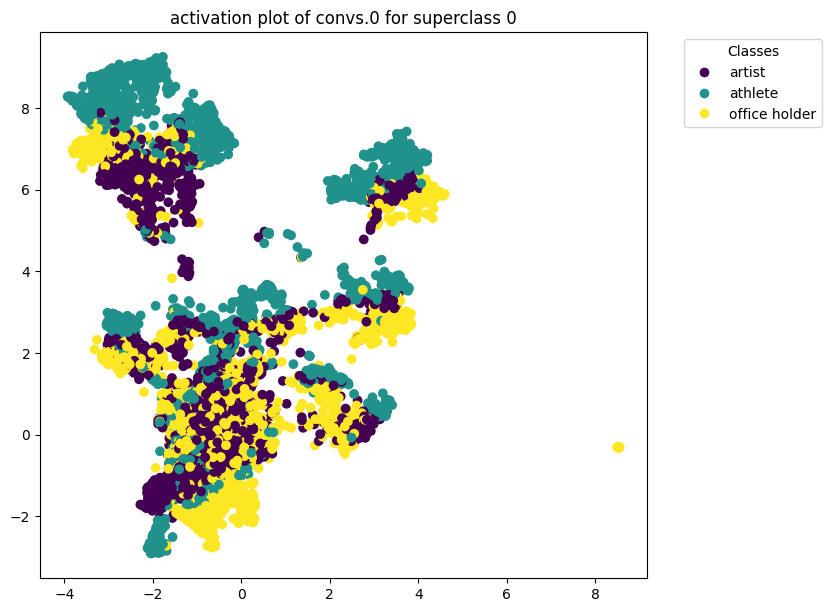

In [160]:
import matplotlib.pyplot as plt



# Set the figure size to make the plot wider
plt.figure(figsize=(10, 6))  # Adjust width (12) and height (6) as desired


# Create scatter plot
scatter = plt.scatter(filted_embedding[:, 0], filted_embedding[:, 1], c=filtered_subclass_lables, cmap="viridis")

# Create legend and position it outside the plot to the right
legend_elements, _ = scatter.legend_elements()
plt.legend(legend_elements, filtered_subclass_names, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjusts the plot to leave room for the legend on the right

plt.title(f"activation plot of {selected_conv} for superclass {filtered_superclass}")

# Display plot
plt.show()


[2 3 4]
['artist', 'athlete', 'office holder']
[0 1 5]
['company', 'educational institution', 'mean of transportation']
[6 7 8]
['building', 'natural place', 'village']
[ 9 10]
['animal', 'plant']
[11 12 13]
['album', 'film', 'writtenWork']


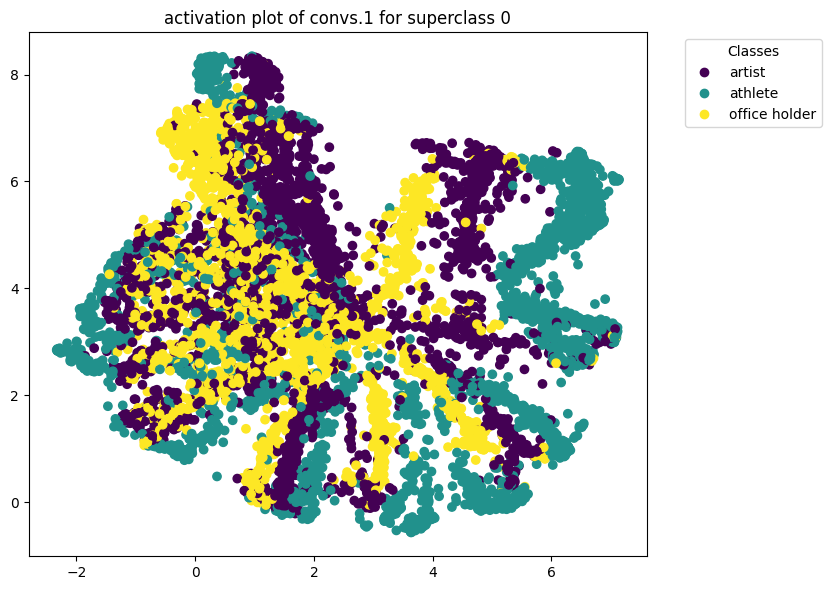

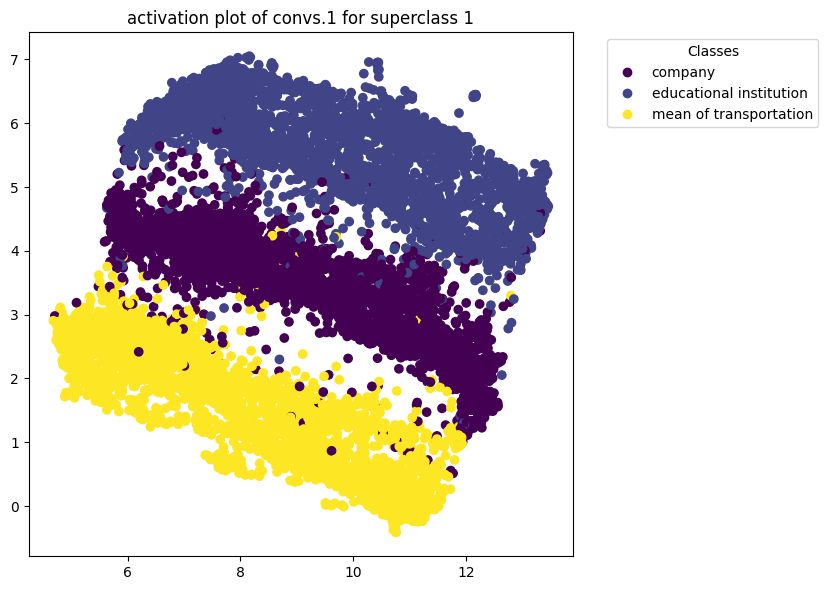

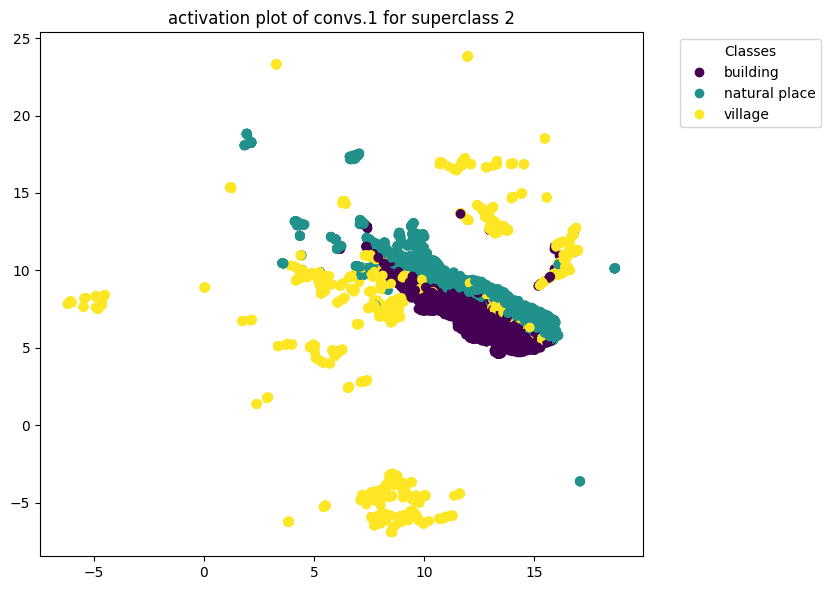

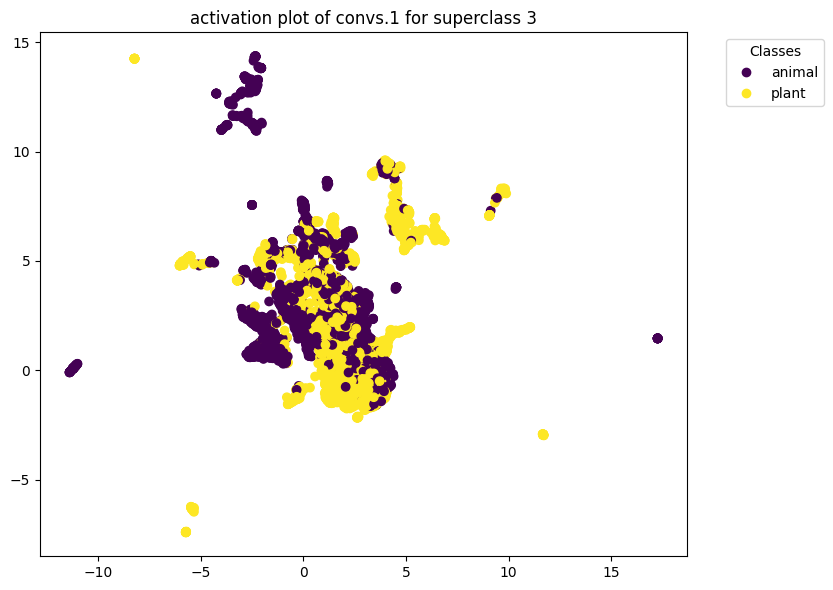

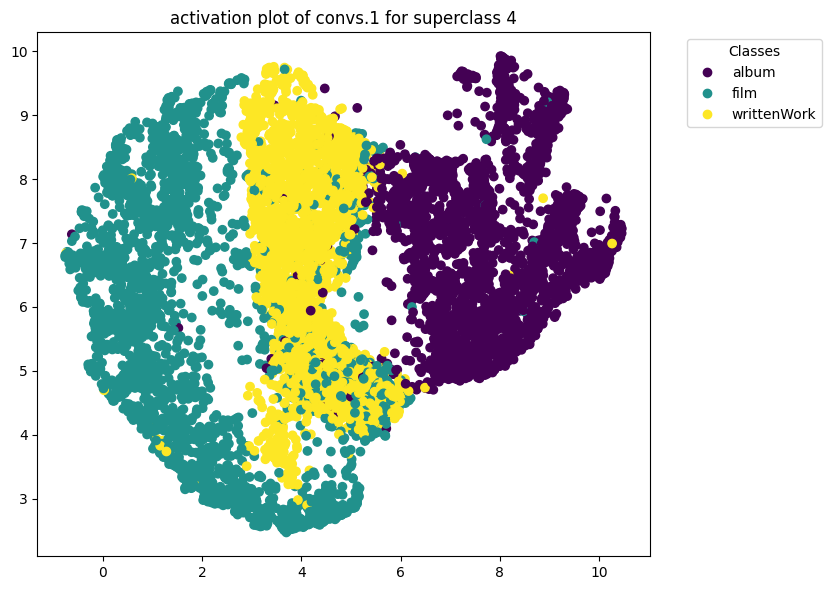

In [173]:
### complete.....
import matplotlib.pyplot as plt


for filtered_superclass in range(5):
 



    ## first  construc the binary mask

    superclasses_np = np.array(superclasses)

    mask = superclasses_np == filtered_superclass

    filtered_activations = selected_activations.numpy()[mask]

    filtered_subclass_lables = selected_subclass_lables.numpy()[mask]


    unique_labels = np.unique(filtered_subclass_lables)

    print(unique_labels)

    filtered_subclass_names = [ name for i, name in enumerate(subclass_names) if i in unique_labels]

    print(filtered_subclass_names)




    reducer = umap.UMAP(random_state=seed)
    filted_embedding = reducer.fit_transform(filtered_activations)





    # Set the figure size to make the plot wider
    plt.figure(figsize=(10, 6))  # Adjust width (12) and height (6) as desired


    # Create scatter plot
    scatter = plt.scatter(filted_embedding[:, 0], filted_embedding[:, 1], c=filtered_subclass_lables, cmap="viridis")

    # Create legend and position it outside the plot to the right
    legend_elements, _ = scatter.legend_elements()
    plt.legend(legend_elements, filtered_subclass_names, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.title(f"activation plot of {selected_conv} for superclass {filtered_superclass}")

    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjusts the plot to leave room for the legend on the right



    plt.savefig(f"activation_plot_{selected_conv}_superclass_{filtered_superclass}.png")

## use the 

In [ ]:
ont_1_mapping = {
        0: 1, # company : other
        1: 1, # educational institution : other
        2: 0, # artist : person
        3: 0, # athlete : person
        4: 0, # office holder : person
        5: 1, # mean of transportation : other
        6: 2, # building : place
        7: 2, # natural place : place
        8: 2, # village : place
        9: 3, # animal : organism
        10: 3, # plant : organism
        11: 4, # album : artwork
        12: 4, # film : artwork
        13: 4, # writtenWork : artwork
    }

## Transformer

In [3]:
path = os.path.join("testRunArticles","collector.pt")
collector = torch.load(path)
epoch_1 = collector[0]
print(epoch_1.keys())

trainSplit = epoch_1["train_outputs"]
activations = trainSplit["activations"]
targets = trainSplit["targets"]
preds = trainSplit["preds"]
true_subclasses = trainSplit["true_subclass"]
print(targets.shape)
print(activations.shape)
print(preds.shape)
print(true_subclasses.shape)

dict_keys(['train_outputs', 'val_outputs'])
torch.Size([80640])
torch.Size([80640, 768])
torch.Size([80640])
torch.Size([80640])


In [3]:
print(trainSplit.keys())

dict_keys(['metrics', 'activations', 'superclass', 'subclass', 'true_subclass', 'alt_subclass', 'targets', 'probs', 'preds', 'losses', 'reweight'])


In [4]:
print(trainSplit["true_subclass"].shape)
print(trainSplit["targets"].shape)

torch.Size([80640])
torch.Size([80640])


In [5]:
print(targets.unique())
print(trainSplit["true_subclass"].unique())

tensor([0, 1, 2, 3, 4])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])


In [6]:
print(activations.shape)
print(targets.shape)
print(preds.shape)
print(true_subclasses.shape)

torch.Size([80640, 768])
torch.Size([80640])
torch.Size([80640])
torch.Size([80640])


In [32]:
selcted_superclass = 3

In [33]:
selected_activations = activations[targets == selcted_superclass]
selected_subclasses = true_subclasses[targets == selcted_superclass]

In [ ]:
import umap

reducer = umap.UMAP()

embedding = reducer.fit_transform(selected_activations)


In [35]:
print(embedding.shape)
print(selected_subclasses.shape)


print(selected_subclasses.unique())

(11593, 2)
torch.Size([11593])
tensor([ 9, 10])


In [36]:
true_subclass_names = [
        " 0 - Company",
        " 1 - Educational Institution",
        " 2 - Artist",
        " 3 - Athlete",
        " 4 - Office Holder",
        " 5 - Mean of Transportation",
        " 6 - Building",
        " 7 - Natural Place",
        " 8 - Village",
        " 9 - Animal",
        "10 - Plant",
        "11 - Album",
        "12 - Film",
        "13 - Written Work",
    
    ]

In [37]:
used_subclass_names = [true_subclass_names[i] for i in selected_subclasses.unique()]
print(used_subclass_names)

[' 9 - Animal', '10 - Plant']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


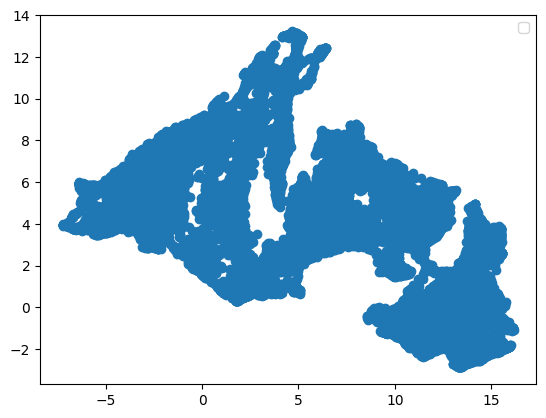

In [23]:
import matplotlib.pyplot as plt
scatter = plt.scatter(embedding[:,0], embedding[:,1])
plt.legend()

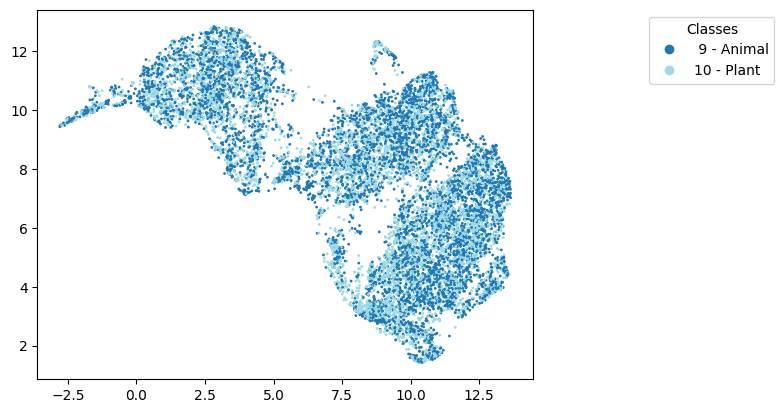

In [38]:
### plot the embedding
import matplotlib.pyplot as plt
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],s =1,c = selected_subclasses, cmap='tab20')
legend = plt.legend(handles=scatter.legend_elements()[0], labels=used_subclass_names, title="Classes", loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()